In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import f_oneway
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm 


# Clasificación
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score
# Import additional libraries for model improvement
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif, RFE

import warnings
warnings.filterwarnings('ignore')

In [47]:
df = pd.read_csv('../data/processed/complete_merged.csv')
df.head()

,Country,Year,Agricultural production index (2014-2016=100),"Balance of payments, current account (million US$)",CPI: Consumer Price Index (2010=100),Economy: Agriculture (% of Gross Value Added),Economy: Industry (% of Gross Value Added),Economy: Services and other activity (% of GVA),Employment in agriculture (% of employed),Employment in industry (% of employed),...,Capital city,Exchange rate (per US$),National currency,"Pop. density (per km2, 2024)","Population (000, 2024)",Region,Sex ratio (m per 100 f),Surface area (km2),UN membership date,Capital_city_pop
0,Afghanistan,2015.0,96.0,4193.0,133.0,22.0,9.6,68.3,44.6,20.7,...,Kabul,77.1,Afghani (AFN),65.7,42648.0,Southern Asia,102.0,652864.0,1946-11-19,4114.0
1,Afghanistan,2020.0,112.0,3137.0,150.0,31.4,13.6,55.0,46.0,18.5,...,Kabul,77.1,Afghani (AFN),65.7,42648.0,Southern Asia,102.0,652864.0,1946-11-19,4114.0
2,Afghanistan,2024.0,111.0,NaN,NaN,35.5,16.9,47.5,46.6,18.3,...,Kabul,77.1,Afghani (AFN),65.7,42648.0,Southern Asia,102.0,652864.0,1946-11-19,4114.0
3,Albania,2015.0,100.0,980.0,111.0,22.5,24.8,52.7,41.3,18.7,...,Tirana,93.9,Lek (ALL),101.9,2792.0,Southern Europe,97.8,28748.0,1955-12-14,484.6
4,Albania,2020.0,106.0,1315.0,121.0,21.9,22.9,55.1,36.2,20.6,...,Tirana,93.9,Lek (ALL),101.9,2792.0,Southern Europe,97.8,28748.0,1955-12-14,484.6


## Problema de Clasificacion

**Clasificar a que rango de GDP per capita pertenece.**

GDP es separa do en 4 categorias dependiendo a cual percentil pertence

In [48]:
df['gdp_class'] = pd.qcut(df["GDP per capita (current US$)"],
                                q=4,
                                labels=False, # Returns integer labels
                                duplicates='drop')

df['gdp_class'].value_counts()

gdp_class
0.0    158
3.0    158
1.0    157
2.0    157
Name: count, dtype: int64

In [49]:
#Education
df["Education: Primary gross enrol. ratio - average"] = (df["Education: Primary gross enrol. ratio - Female (per 100 pop.)"] + df["Education: Primary gross enrol. ratio - Male (per 100 pop.)"]) / 2
df["Education: Primary gross enrol. ratio - brecha"] = df["Education: Primary gross enrol. ratio - Female (per 100 pop.)"] - df["Education: Primary gross enrol. ratio - Male (per 100 pop.)"]
df["Education: Upper Sec. gross enrol. ratio - average"] = (df["Education: Upper Sec. gross enrol. ratio - Female (per 100 pop.)"] + df['Education: Upper Sec. gross enrol. ratio - Male (per 100 pop.)']) / 2
df["Education: Upper Sec. gross enrol brecha"] = df["Education: Upper Sec. gross enrol. ratio - Female (per 100 pop.)"] - df["Education: Upper Sec. gross enrol. ratio - Male (per 100 pop.)"]
df["Education: Lower Sec. gross enrol. ratio - average"] = (df["Education: Lower Sec. gross enrol. ratio - Female (per 100 pop.)"] + df["Education: Lower Sec. gross enrol. ratio - Male (per 100 pop.)"]) / 2
df["Education: Lower Sec. gross enrol brecha"] = df["Education: Lower Sec. gross enrol. ratio - Female (per 100 pop.)"] - df["Education: Lower Sec. gross enrol. ratio - Male (per 100 pop.)"]
#Life Expectancy
df["Life expectancy at birth - average"] = (df["Life expectancy at birth - Female (years)"] + df["Life expectancy at birth - Male (years)"])/2
df["Life expectancy at birth - brecha"] = df["Life expectancy at birth - Female (years)"] - df["Life expectancy at birth - Male (years)"]
#
df.drop(columns=["Education: Primary gross enrol. ratio - Female (per 100 pop.)",
                 "Education: Primary gross enrol. ratio - Male (per 100 pop.)",
                 "Education: Upper Sec. gross enrol. ratio - Female (per 100 pop.)",
                 "Education: Upper Sec. gross enrol. ratio - Male (per 100 pop.)",
                 "Education: Lower Sec. gross enrol. ratio - Female (per 100 pop.)",
                 "Education: Lower Sec. gross enrol. ratio - Male (per 100 pop.)",
                 "Life expectancy at birth - Female (years)",
                 "Life expectancy at birth - Male (years)",
                    ], inplace=True)

In [50]:
general_info = ['Capital city', 'Exchange rate (per US$)',
       'National currency', 'Pop. density (per km2, 2024)',
       'Population (000, 2024)', 'Region', 'Sex ratio (m per 100 f)',
       'Surface area (km2)', 'UN membership date', 'Capital_city_pop'
       ]

social_indicators = [
    'Education: Government expenditure (% of GDP)',
    'Fertility rate, total (live births per woman)',
    'Health: Current expenditure (% of GDP)',
    'Health: Physicians (per 1 000 pop.)',
    'Intentional homicide rate (per 100 000 pop.)',
    'Population growth rate (average annual %)',
    'Refugees and others of concern to UNHCR (000)',
    'Seats held by women in national parliaments (%)',
    'Under five mortality rate (per 1000 live births)',
    'Urban population (% of total population)',
    "Education: Primary gross enrol. ratio - average",
    "Education: Primary gross enrol. brecha",
    "Education: Upper Sec. gross enrol. ratio - average",
    "Education: Upper Sec. gross enrol brecha",
    "Education: Lower Sec. gross enrol. ratio - average",
    "Education: Lower Sec. gross enrol brecha",
    'International migrant stock (% of total pop.)',
    "Life expectancy at birth - average",
    "Life expectancy at birth - brecha",
    'Population age distribution - 0-14 years (%)',
    'Population age distribution - 60+ years (%)',
    ]

economic_indicators = [
    'Agricultural production index (2014-2016=100)',
    'Balance of payments, current account (million US$)',
    'CPI: Consumer Price Index (2010=100)',
    'Economy: Agriculture (% of Gross Value Added)',
    'Economy: Industry (% of Gross Value Added)',
    'Economy: Services and other activity (% of GVA)',
    'Employment in agriculture (% of employed)',
    'Employment in industry (% of employed)',
    'Employment in services (% employed)',
    'GDP growth rate (annual %, const. 2015 prices)',
    'GDP per capita (current US$)',
    'GDP: Gross domestic product (million current US$)',
    'International trade: balance (million current US$)',
    'International trade: exports (million current US$)',
    'International trade: imports (million current US$)',
    'Unemployment (% of labour force)',
    'Labour force participation rate - Female (per 100 pop.)',
    'Labour force participation rate - Male (per 100 pop.)',
    ]

env_infrastructure_indicators = [
    'Energy production, primary (Petajoules)',
    'Energy supply per capita (Gigajoules)',
    'Forested area (% of land area)',
    'Important sites for terrestrial biodiversity protected (%)',
    'Individuals using the Internet (per 100 inhabitants)',
    'Net Official Development Assist. disbursed (% of GNI)',
    'Net Official Development Assist. received (% of GNI)',
    'Research & Development expenditure (% of GDP)',
    'Threatened species (number)',
    'Tourist/visitor arrivals at national borders (000)',
    'CO2 emission estimates - Total (million tons)',
    'CO2 emission estimates - Per capita (tons per capita)',
    'Pop. using safely managed drinking water - Urban (%)',
    'Pop. using safely managed drinking water - Rural (%)',
    'Pop. using safely managed sanitation - Urban (%)',
    'Pop. using safely managed sanitation - Rural (%)',
    ]

In [51]:
df.head()

,Country,Year,Agricultural production index (2014-2016=100),"Balance of payments, current account (million US$)",CPI: Consumer Price Index (2010=100),Economy: Agriculture (% of Gross Value Added),Economy: Industry (% of Gross Value Added),Economy: Services and other activity (% of GVA),Employment in agriculture (% of employed),Employment in industry (% of employed),...,Capital_city_pop,gdp_class,Education: Primary gross enrol. ratio - average,Education: Primary gross enrol. ratio - brecha,Education: Upper Sec. gross enrol. ratio - average,Education: Upper Sec. gross enrol brecha,Education: Lower Sec. gross enrol. ratio - average,Education: Lower Sec. gross enrol brecha,Life expectancy at birth - average,Life expectancy at birth - brecha
0,Afghanistan,2015.0,96.0,4193.0,133.0,22.0,9.6,68.3,44.6,20.7,...,4114.0,0.0,105.65,-39.5,41.1,-26.4,63.65,-33.3,62.30,3.8
1,Afghanistan,2020.0,112.0,3137.0,150.0,31.4,13.6,55.0,46.0,18.5,...,4114.0,0.0,109.45,-42.3,41.7,-24.8,71.90,-36.2,61.60,6.2
2,Afghanistan,2024.0,111.0,NaN,NaN,35.5,16.9,47.5,46.6,18.3,...,4114.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,66.25,3.1
3,Albania,2015.0,100.0,980.0,111.0,22.5,24.8,52.7,41.3,18.7,...,484.6,1.0,113.25,-3.5,98.4,-13.8,107.05,-3.1,78.40,4.2
4,Albania,2020.0,106.0,1315.0,121.0,21.9,22.9,55.1,36.2,20.6,...,484.6,1.0,100.60,-5.2,93.3,-7.8,98.50,-6.2,77.85,4.9


In [52]:
# Basic information about the dataset
print("Dataset shape:", df.shape)
print("\nGDP class distribution:")
print(df['gdp_class'].value_counts().sort_index())
print("\nData types:")
print(df.dtypes.value_counts())
print("\nMissing values summary:")
print(df.isnull().sum().sum(), "total missing values")
print(f"{(df.isnull().sum().sum() / (df.shape[0] * df.shape[1]) * 100):.2f}% of data is missing")

Dataset shape: (696, 80)

GDP class distribution:
gdp_class
0.0    158
1.0    157
2.0    157
3.0    158
Name: count, dtype: int64

Data types:
float64    75
object      5
Name: count, dtype: int64

Missing values summary:
10148 total missing values
18.23% of data is missing


## 1. Target Variable Analysis
Let's analyze the distribution and characteristics of our target variable `gdp_class`.

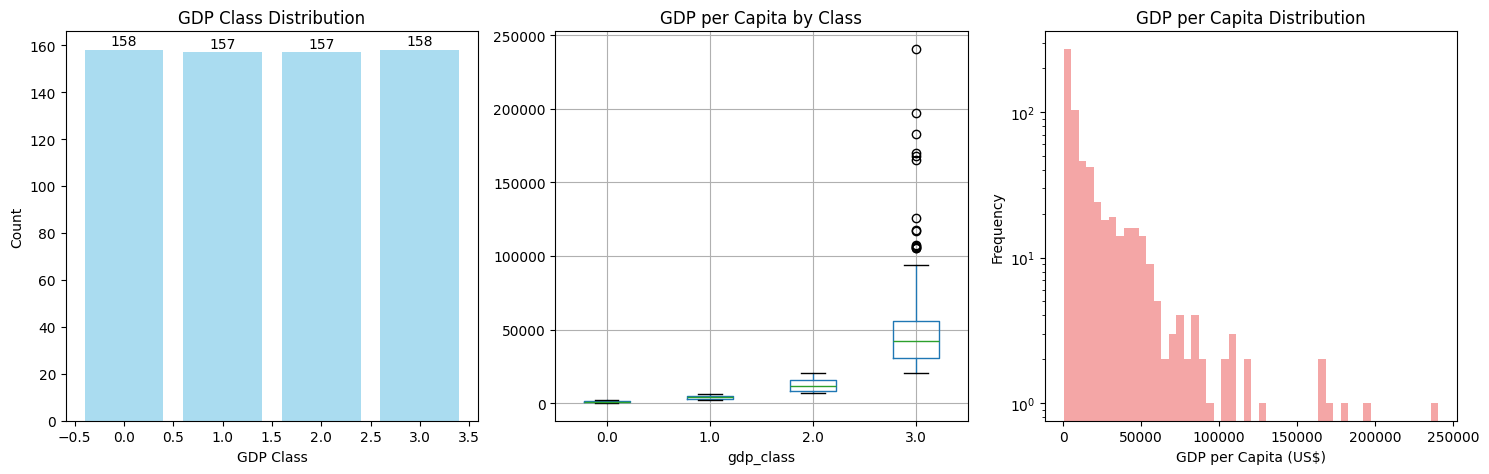

GDP per capita ranges by class:
Class 0: $262 - $2,222 (median: $965)
Class 1: $2,231 - $6,630 (median: $3,950)
Class 2: $6,655 - $20,547 (median: $11,679)
Class 3: $20,708 - $240,535 (median: $42,279)


In [53]:
# Target variable analysis
plt.figure(figsize=(15, 5))

# GDP class distribution
plt.subplot(1, 3, 1)
gdp_counts = df['gdp_class'].value_counts().sort_index()
plt.bar(gdp_counts.index, gdp_counts.values, alpha=0.7, color='skyblue')
plt.title('GDP Class Distribution')
plt.xlabel('GDP Class')
plt.ylabel('Count')
for i, v in enumerate(gdp_counts.values):
    plt.text(i, v + 2, str(v), ha='center')

# GDP per capita distribution by class
plt.subplot(1, 3, 2)
df.boxplot(column='GDP per capita (current US$)', by='gdp_class', ax=plt.gca())
plt.title('GDP per Capita by Class')
plt.suptitle('')  # Remove automatic title

# GDP per capita histogram
plt.subplot(1, 3, 3)
plt.hist(df['GDP per capita (current US$)'].dropna(), bins=50, alpha=0.7, color='lightcoral')
plt.title('GDP per Capita Distribution')
plt.xlabel('GDP per Capita (US$)')
plt.ylabel('Frequency')
plt.yscale('log')  # Log scale due to wide range

plt.tight_layout()
plt.savefig("../src/visualization/classification/categorical_distribution.png", dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

# Show GDP ranges for each class
print("GDP per capita ranges by class:")
for cls in sorted(df['gdp_class'].dropna().unique()):
    gdp_values = df[df['gdp_class'] == cls]['GDP per capita (current US$)'].dropna()
    print(f"Class {int(cls)}: ${gdp_values.min():,.0f} - ${gdp_values.max():,.0f} (median: ${gdp_values.median():,.0f})")

## ANOVA TEST - Feature Selection

In [54]:
def filtrar_columnas_por_completitud(df, columns, threshold=0.80):
    """Filtra una lista de columnas, manteniendo solo aquellas con un porcentaje de datos no nulos >= threshold."""
    total_rows = len(df)
    passing_columns = []
    print(f"\n--- Filtrando columnas (umbral > {threshold*100}%) ---")
    for col in columns:
        if col in df.columns:
            non_null_count = df[col].notna().sum()
            completeness_ratio = non_null_count / total_rows
            if completeness_ratio >= threshold:
                passing_columns.append(col)
                print(f"  [✓] '{col}' pasa el filtro ({completeness_ratio:.1%})")
            else:
                print(f"  [✗] '{col}' RECHAZADA ({completeness_ratio:.1%})")
    return passing_columns

def calcular_asociacion_anova(df, numeric_cols, target_col='gdp_class'):
    """
    Calcula el estadístico F de ANOVA.
    AHORA INCLUYE UN MENSAJE que avisa si una variable es omitida.
    """
    associations = {}
    print("\n--- Calculando Asociación con ANOVA ---")
    groups = df[target_col].dropna().unique()
    print(f"Grupos de GDP encontrados: {sorted(groups)}")
    
    for col in numeric_cols:
        # Crear muestras para cada grupo, eliminando NaN
        samples = []
        valid_groups = []
        
        for g in groups:
            group_data = df[col][df[target_col] == g].dropna()
            if len(group_data) > 0:
                samples.append(group_data)
                valid_groups.append(g)
        
        # Contar cuántos grupos tienen datos
        grupos_con_datos = len(samples)
        
        if grupos_con_datos > 1:
            try:
                # Verificar que tenemos varianza en los datos
                all_values = pd.concat(samples)
                if all_values.var() > 0:  # Solo si hay varianza
                    f_val, p_val = f_oneway(*samples)
                    associations[col] = f_val
                    print(f"  [✓] '{col}' - F={f_val:.3f}, p={p_val:.3f}")
                else:
                    print(f"  [!] '{col}' OMITIDA: Sin varianza en los datos")
            except Exception as e:
                print(f"  [✗] '{col}' ERROR: {str(e)}")
        else:
            print(f"  [!] '{col}' OMITIDA: Solo {grupos_con_datos} grupo(s) con datos")
            
    return pd.Series(associations).sort_values(ascending=False)

def visualizar_asociacion(f_values, title):
    """Crea un gráfico de barras horizontales para visualizar los valores F de ANOVA."""
    if f_values.empty:
        print(f"No hay variables que mostrar para '{title}' después del filtrado.")
        return
    
    # Filtrar valores válidos (F > 0)
    f_values_valid = f_values[f_values > 0]
    
    if f_values_valid.empty:
        print(f"No hay valores F válidos para mostrar en '{title}'.")
        return
        
    plt.figure(figsize=(12, 8))
    
    # Tomar los top 15 valores
    top_values = f_values_valid.head(15)
    
    # Crear gráfico de barras horizontales
    bars = plt.barh(range(len(top_values)), top_values.values, 
                    color='viridis', alpha=0.8)
    
    # Configurar etiquetas del eje Y
    plt.yticks(range(len(top_values)), 
               [name[:50] + '...' if len(name) > 50 else name for name in top_values.index])
    
    plt.title(title, fontsize=16, pad=20)
    plt.xlabel('Fuerza de la Asociación (Estadístico F de ANOVA)', fontsize=12)
    plt.ylabel('Variable', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    
    # Invertir el orden del eje Y para que el mayor esté arriba
    plt.gca().invert_yaxis()
    
    # Añadir valores en las barras
    for i, (bar, val) in enumerate(zip(bars, top_values.values)):
        plt.text(bar.get_width() + max(top_values.values)*0.01, 
                bar.get_y() + bar.get_height()/2, 
                f'{val:.2f}', 
                ha='left', va='center', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # Mostrar estadísticas
    print(f"\nEstadísticas de {title}:")
    print(f"  Variables analizadas: {len(f_values_valid)}")
    print(f"  F-statistic máximo: {f_values_valid.max():.3f}")
    print(f"  F-statistic mínimo: {f_values_valid.min():.3f}")
    print(f"  F-statistic promedio: {f_values_valid.mean():.3f}")

grupos_de_indicadores = {
    "Indicadores Sociales": social_indicators,
    "Indicadores Económicos": economic_indicators,
    "Indicadores de Infraestructura y Medio Ambiente": env_infrastructure_indicators,
}
columnas_a_excluir = ['Country', 'Year']


--- Analyzing Social Indicators ---
  ✓ Fertility rate, total (live births per w | F=303.056, p=0.000000
  ✓ Health: Current expenditure (% of GDP)   | F=21.113, p=0.000000
  ✓ Population growth rate (average annual % | F=63.967, p=0.000000
  ✓ Refugees and others of concern to UNHCR  | F=12.969, p=0.000000
  ✓ Seats held by women in national parliame | F=12.931, p=0.000000
  ✓ Under five mortality rate (per 1000 live | F=256.038, p=0.000000
  ✓ Education: Primary gross enrol. ratio -  | F=0.231, p=0.874581
  ✓ Life expectancy at birth - average       | F=426.407, p=0.000000
  ✓ Life expectancy at birth - brecha        | F=42.685, p=0.000000
  ✓ Population age distribution - 0-14 years | F=457.078, p=0.000000
  ✓ Population age distribution - 60+ years  | F=198.307, p=0.000000
  Total valid features: 11

--- Analyzing Economic Indicators ---
  ✓ Agricultural production index (2014-2016 | F=5.614, p=0.000847
  ✓ Balance of payments, current account (mi | F=15.314, p=0.000000
  ✓ CPI: C

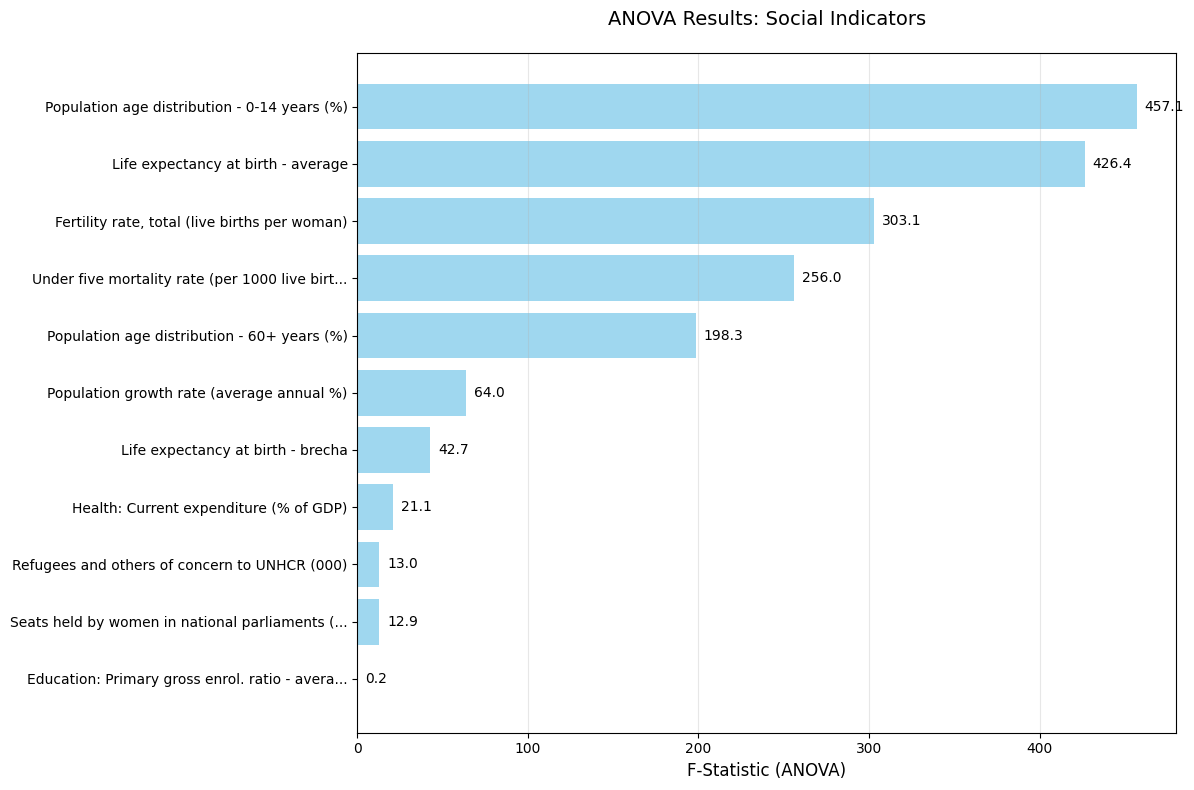


Summary for Social Indicators:
  Features analyzed: 11
  Max F-statistic: 457.078
  Min F-statistic: 0.231
  Mean F-statistic: 163.162


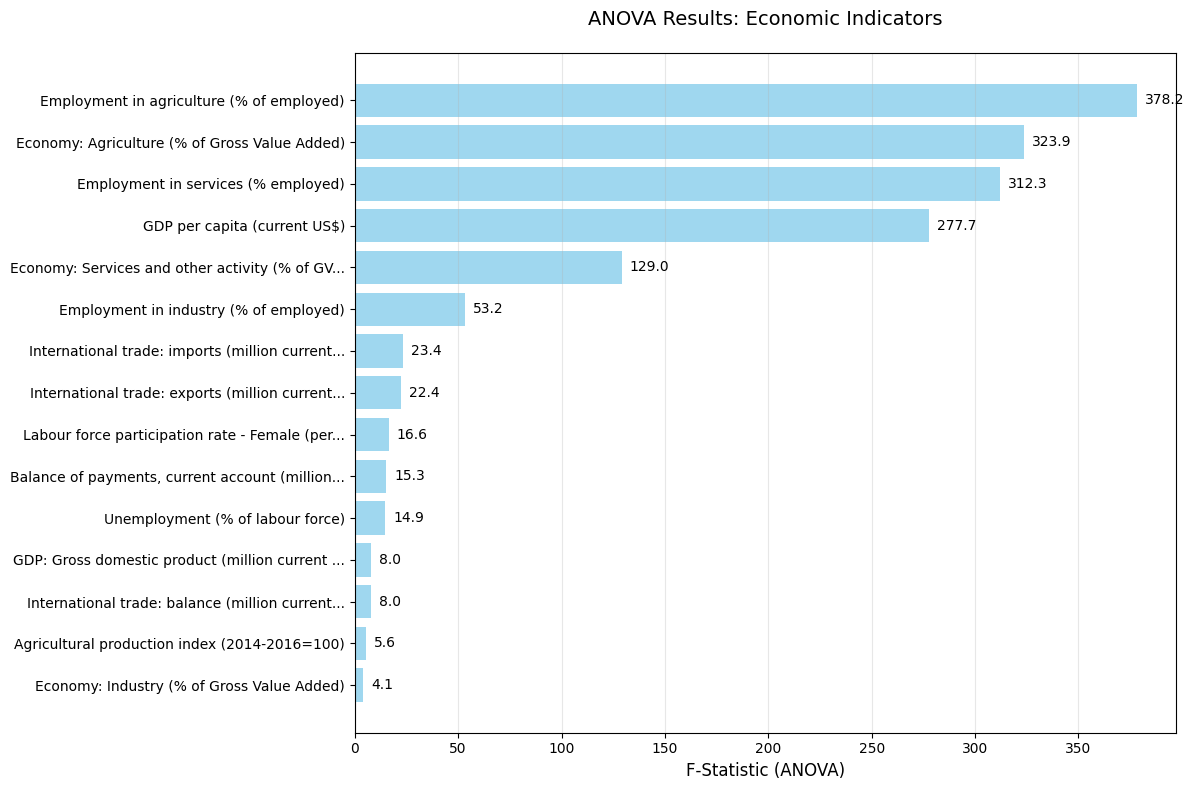


Summary for Economic Indicators:
  Features analyzed: 15
  Max F-statistic: 378.209
  Min F-statistic: 4.103
  Mean F-statistic: 106.177


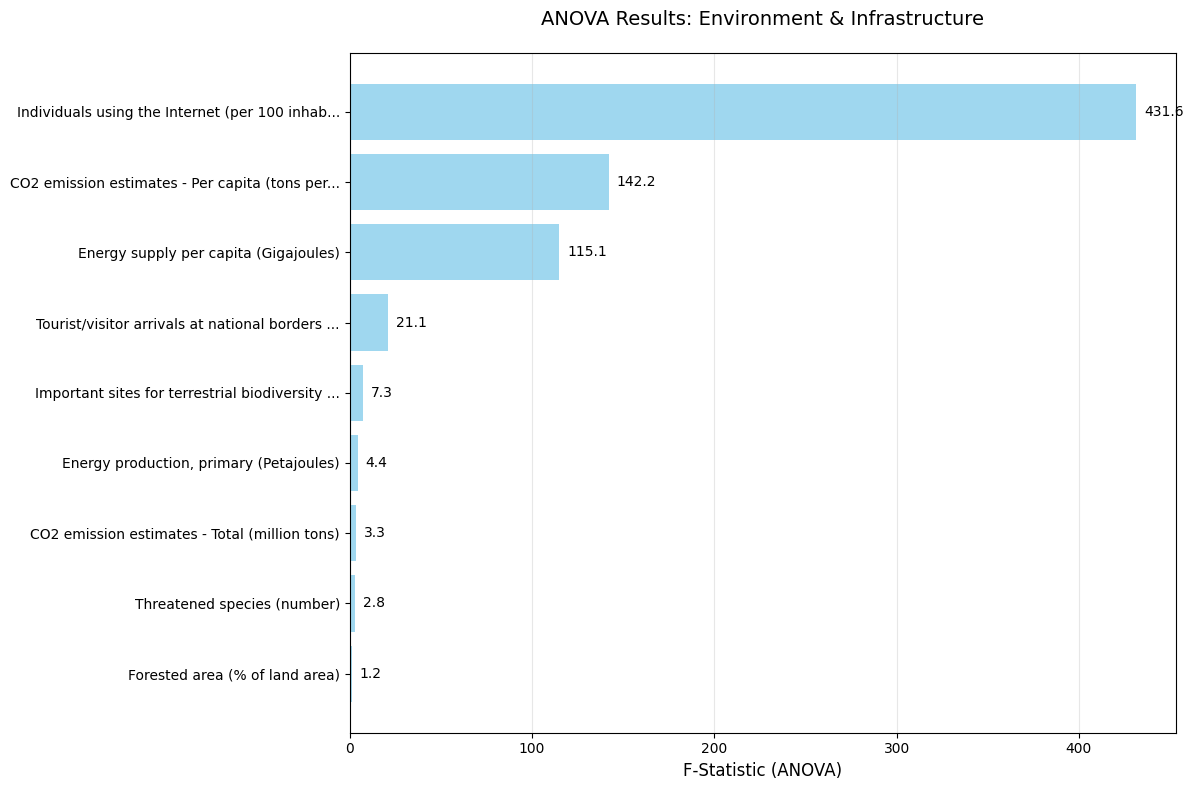


Summary for Environment & Infrastructure:
  Features analyzed: 9
  Max F-statistic: 431.612
  Min F-statistic: 1.199
  Mean F-statistic: 81.014


In [55]:
# Let's create a simplified, working ANOVA analysis
def perform_anova_analysis(df, feature_groups, target='gdp_class', min_completeness=0.8):
    """
    Simplified ANOVA analysis that works correctly
    """
    results = {}
    
    for group_name, features in feature_groups.items():
        print(f"\n--- Analyzing {group_name} ---")
        group_results = {}
        
        for feature in features:
            if feature not in df.columns:
                continue
                
            # Check data completeness
            completeness = df[feature].notna().sum() / len(df)
            if completeness < min_completeness:
                continue
            
            # Prepare data for ANOVA
            clean_data = df[[feature, target]].dropna()
            if len(clean_data) < 20:  # Need minimum observations
                continue
                
            # Create groups
            groups = []
            for class_val in sorted(clean_data[target].unique()):
                group_data = clean_data[clean_data[target] == class_val][feature]
                if len(group_data) > 0:
                    groups.append(group_data)
            
            if len(groups) < 2:
                continue
                
            # Perform ANOVA
            try:
                f_stat, p_value = f_oneway(*groups)
                if not np.isnan(f_stat) and f_stat > 0:
                    group_results[feature] = {
                        'f_statistic': f_stat,
                        'p_value': p_value,
                        'completeness': completeness
                    }
                    print(f"  ✓ {feature[:40]:<40} | F={f_stat:.3f}, p={p_value:.6f}")
            except Exception as e:
                print(f"  ✗ {feature[:40]:<40} | Error: {str(e)}")
        
        results[group_name] = group_results
        print(f"  Total valid features: {len(group_results)}")
    
    return results

def plot_anova_results(results, group_name, top_n=15):
    """
    Plot ANOVA results with proper scaling
    """
    if group_name not in results or not results[group_name]:
        print(f"No results to plot for {group_name}")
        return
    
    # Prepare data
    features = []
    f_stats = []
    
    for feature, stats in results[group_name].items():
        features.append(feature)
        f_stats.append(stats['f_statistic'])
    
    # Sort by F-statistic
    sorted_data = sorted(zip(features, f_stats), key=lambda x: x[1], reverse=True)
    top_data = sorted_data[:top_n]
    
    if not top_data:
        print(f"No data to plot for {group_name}")
        return
    
    # Create plot
    plt.figure(figsize=(12, 8))
    
    features_plot = [item[0] for item in top_data]
    f_stats_plot = [item[1] for item in top_data]
    
    # Truncate long feature names
    features_display = [name[:45] + '...' if len(name) > 45 else name for name in features_plot]
    
    bars = plt.barh(range(len(features_display)), f_stats_plot, color='skyblue', alpha=0.8)
    
    plt.yticks(range(len(features_display)), features_display)
    plt.xlabel('F-Statistic (ANOVA)', fontsize=12)
    plt.title(f'ANOVA Results: {group_name}', fontsize=14, pad=20)
    plt.grid(axis='x', alpha=0.3)
    plt.gca().invert_yaxis()
    
    # Add values on bars
    for i, (bar, f_val) in enumerate(zip(bars, f_stats_plot)):
        plt.text(bar.get_width() + max(f_stats_plot)*0.01, 
                bar.get_y() + bar.get_height()/2, 
                f'{f_val:.1f}', 
                ha='left', va='center', fontsize=10)
    
    plt.tight_layout()
    plt.savefig(f"../src/visualization/classification/ANOVA_test_{group_name}.png", dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    
    # Print summary
    print(f"\nSummary for {group_name}:")
    print(f"  Features analyzed: {len(f_stats_plot)}")
    print(f"  Max F-statistic: {max(f_stats_plot):.3f}")
    print(f"  Min F-statistic: {min(f_stats_plot):.3f}")
    print(f"  Mean F-statistic: {np.mean(f_stats_plot):.3f}")

# Run the analysis
feature_groups = {
    "Social Indicators": social_indicators,
    "Economic Indicators": economic_indicators,  
    "Environment & Infrastructure": env_infrastructure_indicators
}

anova_results = perform_anova_analysis(df, feature_groups)

# Plot results for each group
for group_name in feature_groups.keys():
    plot_anova_results(anova_results, group_name)

In [56]:
categorical_cols = ["Region"]



=== ANÁLISIS DETALLADO: REGIÓN vs GDP CLASS ===
Número total de regiones: 22
Observaciones totales: 696

Distribución de países por región:
Region
Caribbean             78
Eastern Africa        60
Western Asia          54
Western Africa        51
Southern Europe       48
South America         42
Northern Europe       39
South-eastern Asia    33
Eastern Europe        30
Western Europe        27
Name: count, dtype: int64


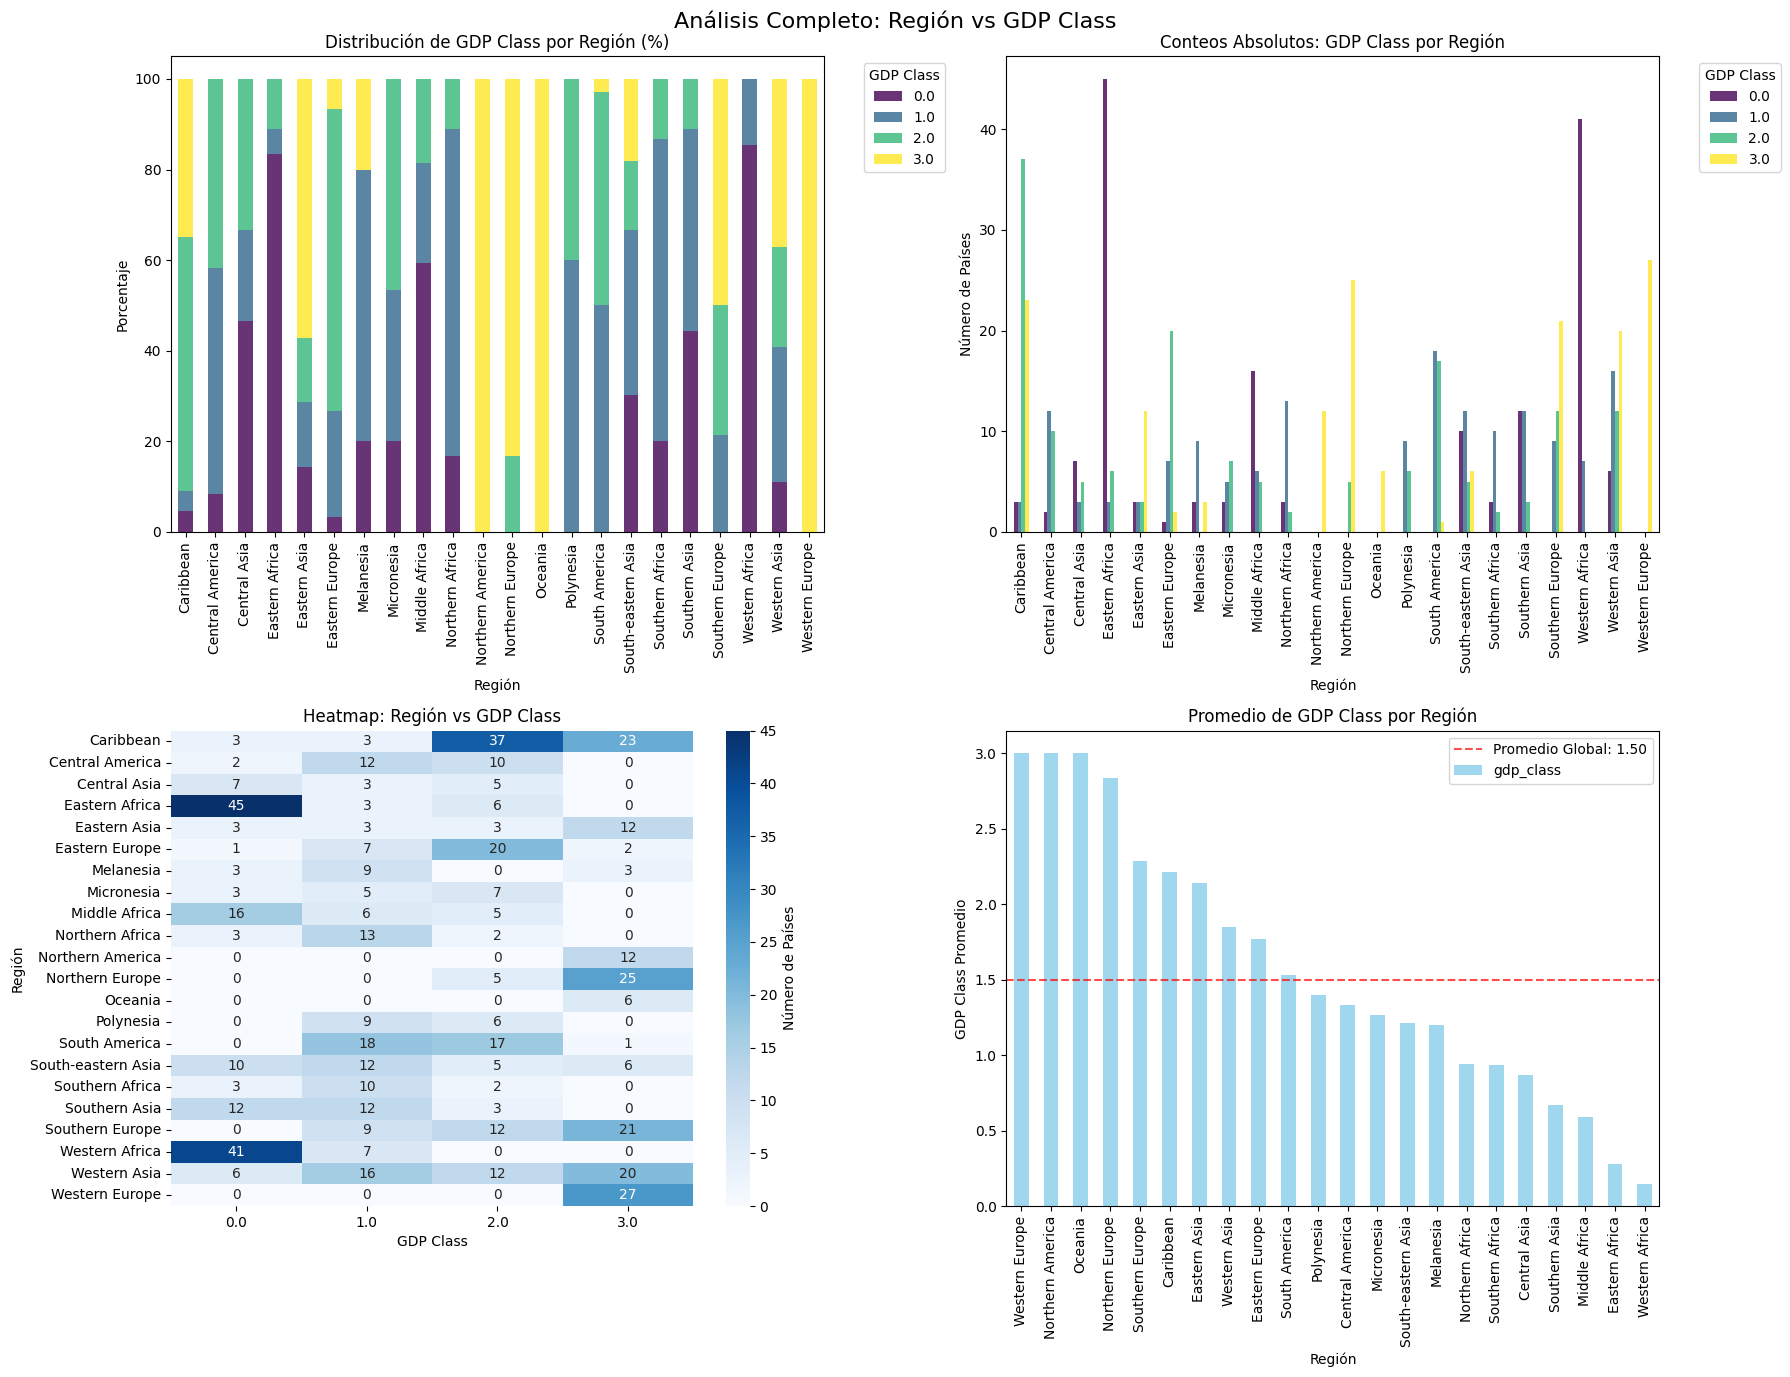

In [57]:
# Análisis detallado: Region vs GDP Class
print("=== ANÁLISIS DETALLADO: REGIÓN vs GDP CLASS ===")
print(f"Número total de regiones: {df['Region'].nunique()}")
print(f"Observaciones totales: {len(df)}")

# 1. Información básica por región
print("\nDistribución de países por región:")
region_counts = df['Region'].value_counts().sort_values(ascending=False)
print(region_counts.head(10))

# 2. Visualizaciones múltiples
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
fig.suptitle('Análisis Completo: Región vs GDP Class', fontsize=16, y=0.98)

# 2.1 Distribución porcentual (barras apiladas)
ax1 = axes[0, 0]
region_gdp_pct = pd.crosstab(df['Region'], df['gdp_class'], normalize='index') * 100
region_gdp_pct.plot(kind='bar', stacked=True, ax=ax1, colormap='viridis', alpha=0.8)
ax1.set_title('Distribución de GDP Class por Región (%)', fontsize=12)
ax1.set_xlabel('Región')
ax1.set_ylabel('Porcentaje')
ax1.legend(title='GDP Class', bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.tick_params(axis='x', rotation=90)

# 2.2 Conteos absolutos
ax2 = axes[0, 1]
region_gdp_counts = pd.crosstab(df['Region'], df['gdp_class'])
region_gdp_counts.plot(kind='bar', ax=ax2, colormap='viridis', alpha=0.8)
ax2.set_title('Conteos Absolutos: GDP Class por Región', fontsize=12)
ax2.set_xlabel('Región')
ax2.set_ylabel('Número de Países')
ax2.legend(title='GDP Class', bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.tick_params(axis='x', rotation=90)

# 2.3 Heatmap
ax3 = axes[1, 0]
sns.heatmap(region_gdp_counts, annot=True, fmt='d', cmap='Blues', ax=ax3, cbar_kws={'label': 'Número de Países'})
ax3.set_title('Heatmap: Región vs GDP Class', fontsize=12)
ax3.set_xlabel('GDP Class')
ax3.set_ylabel('Región')

# 2.4 Promedio de GDP Class por región
ax4 = axes[1, 1]
region_avg_gdp = df.groupby('Region')['gdp_class'].mean().sort_values(ascending=False)
region_avg_gdp.plot(kind='bar', ax=ax4, color='skyblue', alpha=0.8)
ax4.set_title('Promedio de GDP Class por Región', fontsize=12)
ax4.set_xlabel('Región')
ax4.set_ylabel('GDP Class Promedio')
ax4.tick_params(axis='x', rotation=90)
ax4.axhline(y=df['gdp_class'].mean(), color='red', linestyle='--', alpha=0.7, label=f'Promedio Global: {df["gdp_class"].mean():.2f}')
ax4.legend()

plt.tight_layout()
plt.savefig(f"../src/visualization/classification/region_vs_gdpClass.png", dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

## Correlation Matrix

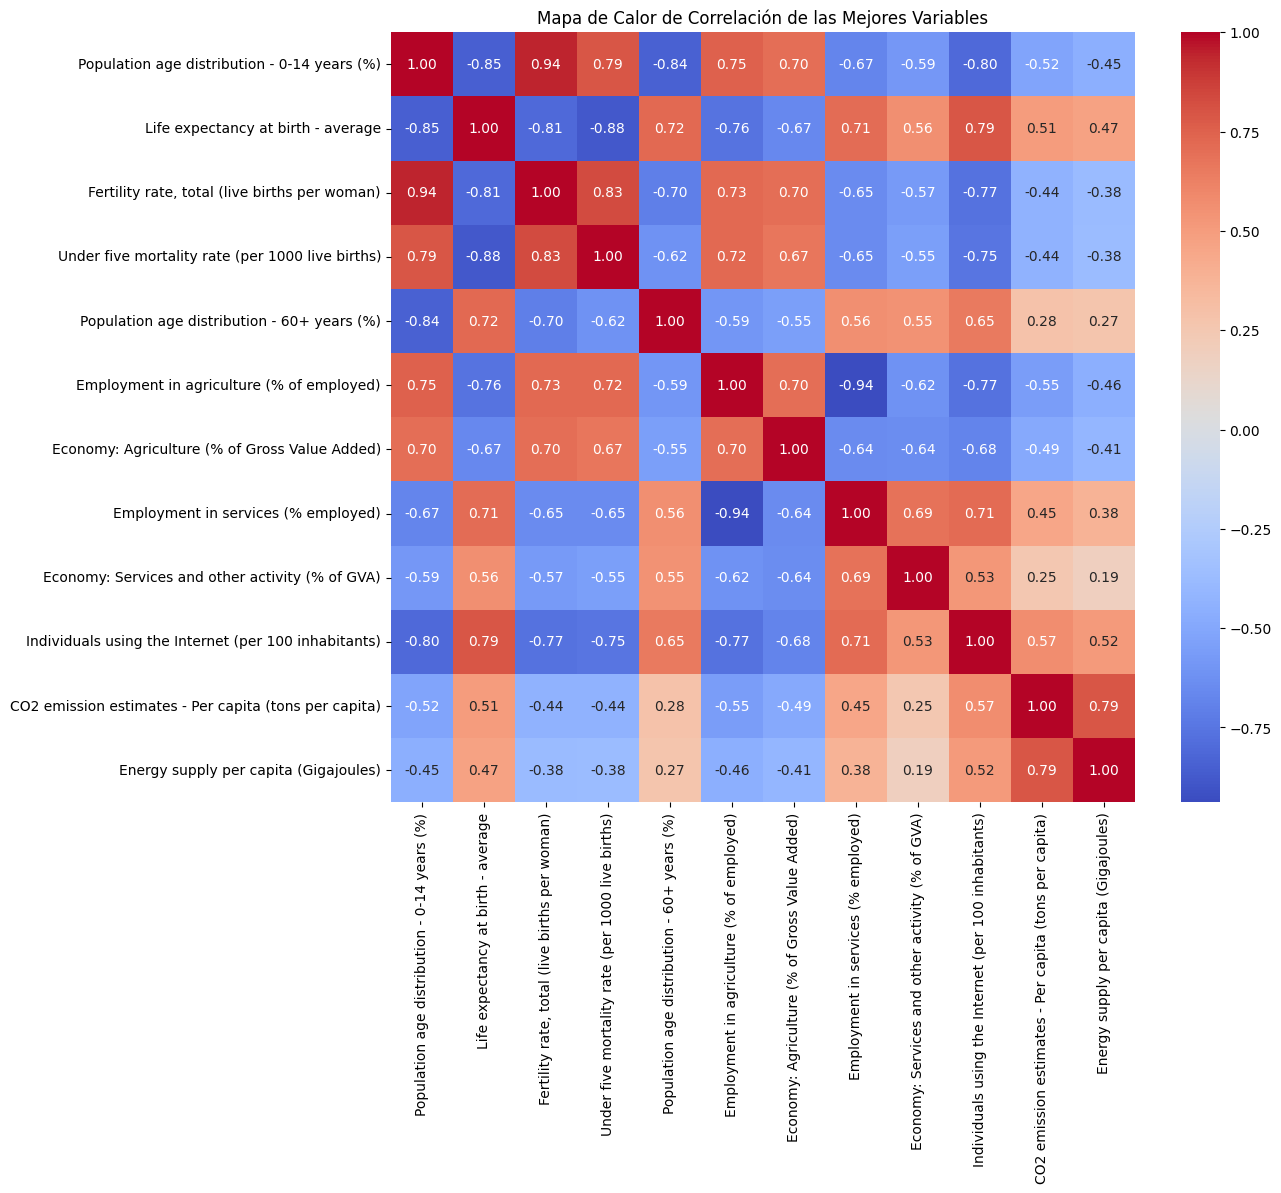

In [58]:
top_features = [
#Social Indicators
"Population age distribution - 0-14 years (%)",
"Life expectancy at birth - average",
"Fertility rate, total (live births per woman)",
"Under five mortality rate (per 1000 live births)",
"Population age distribution - 60+ years (%)",
#Economic Indicators
"Employment in agriculture (% of employed)",
"Economy: Agriculture (% of Gross Value Added)",
"Employment in services (% employed)",
"Economy: Services and other activity (% of GVA)",
#Env-Infra Indicators
"Individuals using the Internet (per 100 inhabitants)",
"CO2 emission estimates - Per capita (tons per capita)",
"Energy supply per capita (Gigajoules)",
]

vif_df = df[top_features].dropna()
correlation_matrix = df[top_features].corr()

# 3. Visualízala con un mapa de calor
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Mapa de Calor de Correlación de las Mejores Variables')
plt.savefig("../src/visualization/classification/cor_matrix.png", dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

In [59]:
def showVIF(corr_data):
    datos = sm.add_constant(corr_data)

    vif_data = pd.DataFrame()
    vif_data['Feature'] = datos.columns
    vif_data['VIF'] = [variance_inflation_factor(datos.values, i) for i in range(datos.shape[1])]
    print(vif_data)

def corrPercentage(corr_matrix):
    umbral = 0.7

    pares_correlacionados = []

    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i,j]) > umbral:
                pares_correlacionados.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i,j]))

    for par in pares_correlacionados:
        print(f"Alta Correlacion entre {par[0]} y {par[1]} : {par[2]*100:.2f}%")

In [60]:
showVIF(vif_df)

                                              Feature          VIF
0                                               const  1154.541529
1        Population age distribution - 0-14 years (%)    33.878414
2                  Life expectancy at birth - average     9.009576
3       Fertility rate, total (live births per woman)    17.962810
4    Under five mortality rate (per 1000 live births)     7.497601
5         Population age distribution - 60+ years (%)     6.699419
6           Employment in agriculture (% of employed)    13.234342
7       Economy: Agriculture (% of Gross Value Added)     2.857919
8                 Employment in services (% employed)    11.196567
9     Economy: Services and other activity (% of GVA)     2.709573
10  Individuals using the Internet (per 100 inhabi...     4.271374
11  CO2 emission estimates - Per capita (tons per ...     3.954174
12              Energy supply per capita (Gigajoules)     2.654078


In [61]:
corrPercentage(correlation_matrix)

Alta Correlacion entre Life expectancy at birth - average y Population age distribution - 0-14 years (%) : -84.96%
Alta Correlacion entre Fertility rate, total (live births per woman) y Population age distribution - 0-14 years (%) : 93.95%
Alta Correlacion entre Fertility rate, total (live births per woman) y Life expectancy at birth - average : -80.80%
Alta Correlacion entre Under five mortality rate (per 1000 live births) y Population age distribution - 0-14 years (%) : 79.26%
Alta Correlacion entre Under five mortality rate (per 1000 live births) y Life expectancy at birth - average : -88.39%
Alta Correlacion entre Under five mortality rate (per 1000 live births) y Fertility rate, total (live births per woman) : 82.89%
Alta Correlacion entre Population age distribution - 60+ years (%) y Population age distribution - 0-14 years (%) : -84.09%
Alta Correlacion entre Population age distribution - 60+ years (%) y Life expectancy at birth - average : 72.11%
Alta Correlacion entre Populati

In [62]:
lista_final_features = [
    'Population age distribution - 0-14 years (%)',         
    'Life expectancy at birth - average',            
    'Employment in agriculture (% of employed)',     
    'Individuals using the Internet (per 100 inhabitants)', 
    'CO2 emission estimates - Per capita (tons per capita)', 
    'Economy: Services and other activity (% of GVA)'      
]

correlation_matrix_final = df[lista_final_features].corr()

# Ejecuta tu función VIF sobre esta matriz de correlación limpia
print("\n--- VIF calculado sobre la lista de variables final y limpia ---")
showVIF(df[lista_final_features].dropna()) # Es importante usar dropna() para que VIF funcione


--- VIF calculado sobre la lista de variables final y limpia ---
                                             Feature         VIF
0                                              const  615.317742
1       Population age distribution - 0-14 years (%)    4.962189
2                 Life expectancy at birth - average    4.876963
3          Employment in agriculture (% of employed)    3.435736
4  Individuals using the Internet (per 100 inhabi...    4.035075
5  CO2 emission estimates - Per capita (tons per ...    1.759698
6    Economy: Services and other activity (% of GVA)    1.928141


# Consturction of Model

In [63]:
dummies = pd.get_dummies(df["Region"], dtype=int)
df = df.join(dummies)

In [ ]:
# Get the names of the one-hot encoded region columns
region_columns = [col for col in df.columns if col in dummies.columns]
model_columns = lista_final_features + region_columns + ['gdp_class']
df_model = df[model_columns].copy()
df_model.dropna(inplace=True)

In [65]:
# Analyze the model dataset structure

numerical_features = top_features
regional_features = region_columns
target = 'gdp_class'

print(f"Dataset composition:")
print(f"  Numerical features: {len(numerical_features)}")
print(f"  Regional dummy features: {len(regional_features)}")
print(f"  Target variable: 1")
print(f"  Total columns: {len(df_model.columns)}")

# Check target distribution in model dataset
print(f"\nTarget variable distribution in df_model:")
target_dist = df_model['gdp_class'].value_counts().sort_index()
print(target_dist)

# Calculate target percentages
target_pct = (target_dist / target_dist.sum() * 100).round(1)
print(f"\nTarget percentages:")
for class_val, pct in target_pct.items():
    print(f"  Class {int(class_val)}: {pct}%")

Dataset composition:
  Numerical features: 12
  Regional dummy features: 22
  Target variable: 1
  Total columns: 29

Target variable distribution in df_model:
gdp_class
0.0    147
1.0    149
2.0    125
3.0    127
Name: count, dtype: int64

Target percentages:
  Class 0: 26.8%
  Class 1: 27.2%
  Class 2: 22.8%
  Class 3: 23.2%


In [66]:
X = df_model.drop('gdp_class', axis=1)
y = df_model['gdp_class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [67]:
model = LogisticRegression(max_iter=200)
model.fit(X_train,y_train)

y_pred = model.predict(X_test)

In [68]:
model.score(X_test,y_test)

0.806060606060606

In [69]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.88      0.90      0.89        49
         1.0       0.70      0.79      0.75        48
         2.0       0.82      0.65      0.73        43
         3.0       0.85      0.92      0.88        25

    accuracy                           0.81       165
   macro avg       0.81      0.82      0.81       165
weighted avg       0.81      0.81      0.80       165



In [70]:
model = DecisionTreeClassifier()
model.fit(X_train,y_train)

y_pred = model.predict(X_test)

In [71]:
model.score(X_test,y_test)

0.7212121212121212

In [72]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.82      0.84      0.83        49
         1.0       0.61      0.69      0.65        48
         2.0       0.68      0.58      0.62        43
         3.0       0.83      0.80      0.82        25

    accuracy                           0.72       165
   macro avg       0.74      0.73      0.73       165
weighted avg       0.72      0.72      0.72       165



In [73]:
resultados = []
for i in range(1,11):
    model = DecisionTreeClassifier(max_depth=i)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    exactitud = accuracy_score(y_test,y_pred)
    resultados.append(exactitud)
    print(f"Resultado para {i} : {exactitud}")

Resultado para 1 : 0.4484848484848485
Resultado para 2 : 0.6545454545454545
Resultado para 3 : 0.703030303030303
Resultado para 4 : 0.7393939393939394
Resultado para 5 : 0.7272727272727273
Resultado para 6 : 0.7333333333333333
Resultado para 7 : 0.6727272727272727
Resultado para 8 : 0.7393939393939394
Resultado para 9 : 0.7212121212121212
Resultado para 10 : 0.7333333333333333


# Model Performance Analysis & Improvements

In [74]:
# 1. DATA PREPROCESSING IMPROVEMENTS
print("=== STEP 1: IMPROVED DATA PREPROCESSING ===")

# Recreate train-test split with stratification and fixed random state for reproducibility
X = df_model.drop('gdp_class', axis=1)
y = df_model['gdp_class']

# Use stratified split to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3, 
    random_state=42, 
    stratify=y  # Ensures balanced classes in train/test
)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Training class distribution:\n{y_train.value_counts().sort_index()}")
print(f"Test class distribution:\n{y_test.value_counts().sort_index()}")

# Check for feature scaling needs
print(f"\nFeature scaling analysis:")
print(f"Feature ranges (min-max):")
for i, col in enumerate(X.columns[:5]):  # Show first 5 features
    print(f"  {col[:30]:<30}: {X[col].min():.2f} to {X[col].max():.2f}")
print("  ... (showing first 5 features)")

# Features have different scales - scaling will be important for certain models

=== STEP 1: IMPROVED DATA PREPROCESSING ===
Training set shape: (383, 28)
Test set shape: (165, 28)
Training class distribution:
gdp_class
0.0    103
1.0    104
2.0     87
3.0     89
Name: count, dtype: int64
Test class distribution:
gdp_class
0.0    44
1.0    45
2.0    38
3.0    38
Name: count, dtype: int64

Feature scaling analysis:
Feature ranges (min-max):
  Population age distribution - : 10.50 to 49.20
  Life expectancy at birth - ave: 39.90 to 85.65
  Employment in agriculture (% o: 0.10 to 86.30
  Individuals using the Internet: 0.00 to 100.00
  CO2 emission estimates - Per c: 0.00 to 29.60
  ... (showing first 5 features)


In [75]:

models = {
    'Logistic Regression': Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression(max_iter=1000, random_state=42))
    ]),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'SVM': Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', SVC(random_state=42))
    ]),
    'KNN': Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', KNeighborsClassifier())
    ])
}

# Cross-validation with stratified folds
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
model_results = {}

print("Cross-validation results (5-fold):")
print("-" * 60)

for name, model in models.items():
    # Perform cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
    
    model_results[name] = {
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'cv_scores': cv_scores
    }
    
    print(f"{name:<20}: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Find best model
best_model = max(model_results.items(), key=lambda x: x[1]['cv_mean'])
print(f"\nBest model by CV: {best_model[0]} with {best_model[1]['cv_mean']:.4f} accuracy")

Cross-validation results (5-fold):
------------------------------------------------------------
Logistic Regression : 0.7886 (+/- 0.0636)
Decision Tree       : 0.7468 (+/- 0.0780)
Random Forest       : 0.8199 (+/- 0.0501)
Gradient Boosting   : 0.8067 (+/- 0.0803)
SVM                 : 0.7259 (+/- 0.0707)
KNN                 : 0.6764 (+/- 0.0988)

Best model by CV: Random Forest with 0.8199 accuracy


In [76]:
#Hyperparameter Tuning for Top Models
# Define parameter grids for top models
param_grids = {
    'Random Forest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 15, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'Gradient Boosting': {
        'n_estimators': [100, 200],
        'learning_rate': [0.05, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 5]
    },
    'Logistic Regression': {
        'classifier__C': [0.1, 1, 10, 100],
        'classifier__penalty': ['l1', 'l2'],
        'classifier__solver': ['liblinear', 'saga']
    }
}

# Select top 3 models for hyperparameter tuning
top_models = sorted(model_results.items(), key=lambda x: x[1]['cv_mean'], reverse=True)[:3]
optimized_models = {}

for model_name, _ in top_models:
    if model_name in param_grids:
        print(f"\nOptimizing {model_name}...")
        
        # Grid search with cross-validation
        grid_search = GridSearchCV(
            models[model_name],
            param_grids[model_name],
            cv=3,  
            scoring='accuracy',
            n_jobs=-1,
            verbose=0
        )
        
        grid_search.fit(X_train, y_train)
        optimized_models[model_name] = grid_search
        
        print(f"Best parameters: {grid_search.best_params_}")
        print(f"Best CV score: {grid_search.best_score_:.4f}")

print(f"\nCompleted hyperparameter optimization for {len(optimized_models)} models")


Optimizing Random Forest...
Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best CV score: 0.8355

Optimizing Gradient Boosting...
Best parameters: {'learning_rate': 0.2, 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 200}
Best CV score: 0.8172

Optimizing Logistic Regression...
Best parameters: {'classifier__C': 10, 'classifier__penalty': 'l2', 'classifier__solver': 'saga'}
Best CV score: 0.7964

Completed hyperparameter optimization for 3 models


In [77]:
#Model Evaluation

final_results = {}

# Original models
for name, model in models.items():
    model.fit(X_train, y_train)
    test_score = model.score(X_test, y_test)
    y_pred = model.predict(X_test)
    
    final_results[f"{name} (Default)"] = {
        'test_accuracy': test_score,
        'cv_accuracy': model_results[name]['cv_mean'],
        'predictions': y_pred
    }

# Optimized models
for name, grid_search in optimized_models.items():
    test_score = grid_search.score(X_test, y_test)
    y_pred = grid_search.predict(X_test)
    
    final_results[f"{name} (Optimized)"] = {
        'test_accuracy': test_score,
        'cv_accuracy': grid_search.best_score_,
        'predictions': y_pred
    }

# Display results
print("Final Model Comparison:")
print("-" * 80)
print(f"{'Model':<25} {'CV Accuracy':<15} {'Test Accuracy':<15} {'Improvement':<15}")
print("-" * 80)

for model_name, results in sorted(final_results.items(), key=lambda x: x[1]['test_accuracy'], reverse=True):
    cv_acc = results['cv_accuracy']
    test_acc = results['test_accuracy']
    improvement = "N/A" if "Default" in model_name else f"{test_acc - final_results.get(model_name.replace(' (Optimized)', ' (Default)'), {}).get('test_accuracy', 0):.4f}"
    
    print(f"{model_name:<25} {cv_acc:<15.4f} {test_acc:<15.4f} {improvement:<15}")

# Select best model
best_final_model = max(final_results.items(), key=lambda x: x[1]['test_accuracy'])
print(f"\n🏆 BEST MODEL: {best_final_model[0]}")
print(f"   Test Accuracy: {best_final_model[1]['test_accuracy']:.4f}")
print(f"   CV Accuracy: {best_final_model[1]['cv_accuracy']:.4f}")

Final Model Comparison:
--------------------------------------------------------------------------------
Model                     CV Accuracy     Test Accuracy   Improvement    
--------------------------------------------------------------------------------
Gradient Boosting (Optimized) 0.8172          0.8727          0.0182         
Random Forest (Optimized) 0.8355          0.8667          0.0061         
Random Forest (Default)   0.8199          0.8606          N/A            
Gradient Boosting (Default) 0.8067          0.8545          N/A            
Logistic Regression (Default) 0.7886          0.8121          N/A            
Decision Tree (Default)   0.7468          0.8121          N/A            
Logistic Regression (Optimized) 0.7964          0.8061          -0.0061        
KNN (Default)             0.6764          0.7636          N/A            
SVM (Default)             0.7259          0.7515          N/A            

🏆 BEST MODEL: Gradient Boosting (Optimized)
   Test Accur


Detailed Classification Report for Gradient Boosting (Optimized):
              precision    recall  f1-score   support

         0.0       0.88      0.86      0.87        44
         1.0       0.82      0.80      0.81        45
         2.0       0.83      0.92      0.88        38
         3.0       0.97      0.92      0.95        38

    accuracy                           0.87       165
   macro avg       0.88      0.88      0.88       165
weighted avg       0.87      0.87      0.87       165



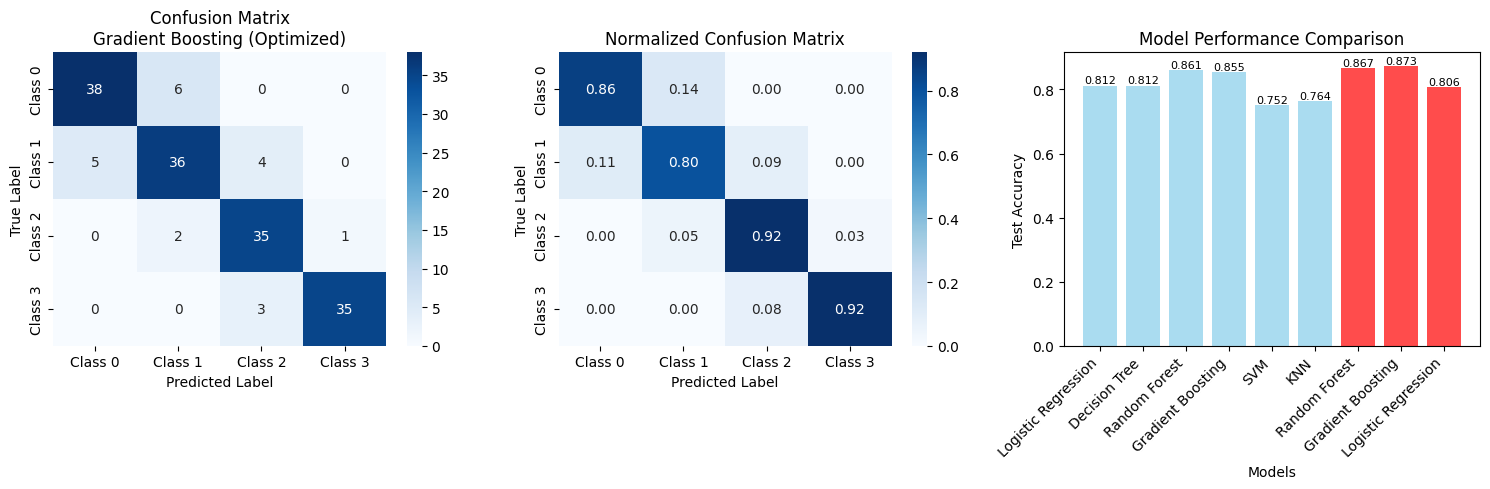


Per-class performance analysis:
Class 0 (Lowest GDP): Precision, Recall, F1-score
Class 1 (Low-Medium GDP): Precision, Recall, F1-score
Class 2 (Medium-High GDP): Precision, Recall, F1-score
Class 3 (Highest GDP): Precision, Recall, F1-score


In [78]:
# Best Model Analysis

best_model_name = best_final_model[0]
best_predictions = best_final_model[1]['predictions']

# Classification report
print(f"\nDetailed Classification Report for {best_model_name}:")
print(classification_report(y_test, best_predictions))

# Confusion Matrix
plt.figure(figsize=(15, 5))

# Confusion Matrix - Raw counts
plt.subplot(1, 3, 1)
cm = confusion_matrix(y_test, best_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'],
            yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'])
plt.title(f'Confusion Matrix\n{best_model_name}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Confusion Matrix - Normalized
plt.subplot(1, 3, 2)
cm_norm = confusion_matrix(y_test, best_predictions, normalize='true')
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'],
            yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'])
plt.title('Normalized Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Model comparison visualization
plt.subplot(1, 3, 3)
model_names = [name.replace(' (Optimized)', '*').replace(' (Default)', '') for name in final_results.keys()]
test_accuracies = [results['test_accuracy'] for results in final_results.values()]

colors = ['red' if '*' in name else 'skyblue' for name in model_names]
bars = plt.bar(range(len(model_names)), test_accuracies, color=colors, alpha=0.7)

plt.title('Model Performance Comparison')
plt.ylabel('Test Accuracy')
plt.xlabel('Models')
plt.xticks(range(len(model_names)), [name.replace('*', '') for name in model_names], rotation=45, ha='right')

# Add accuracy values on bars
for i, (bar, acc) in enumerate(zip(bars, test_accuracies)):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001, 
             f'{acc:.3f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig("../src/visualization/classification/model_results.png", dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

# Performance per class
print(f"\nPer-class performance analysis:")
print("Class 0 (Lowest GDP): Precision, Recall, F1-score")
print("Class 1 (Low-Medium GDP): Precision, Recall, F1-score") 
print("Class 2 (Medium-High GDP): Precision, Recall, F1-score")
print("Class 3 (Highest GDP): Precision, Recall, F1-score")

Top 15 Most Important Features:
------------------------------------------------------------
 1. CO2 emission estimates - Per capita (tons per | 0.3456
 2. Life expectancy at birth - average            | 0.2728
 3. Employment in agriculture (% of employed)     | 0.1665
 4. Population age distribution - 0-14 years (%)  | 0.0711
 5. Economy: Services and other activity (% of GV | 0.0483
 6. Individuals using the Internet (per 100 inhab | 0.0418
 7. Polynesia                                     | 0.0112
 8. Middle Africa                                 | 0.0079
 9. Central America                               | 0.0078
10. Southern Europe                               | 0.0041
11. Melanesia                                     | 0.0040
12. Southern Asia                                 | 0.0039
13. Central Asia                                  | 0.0038
14. Eastern Europe                                | 0.0027
15. Southern Africa                               | 0.0027


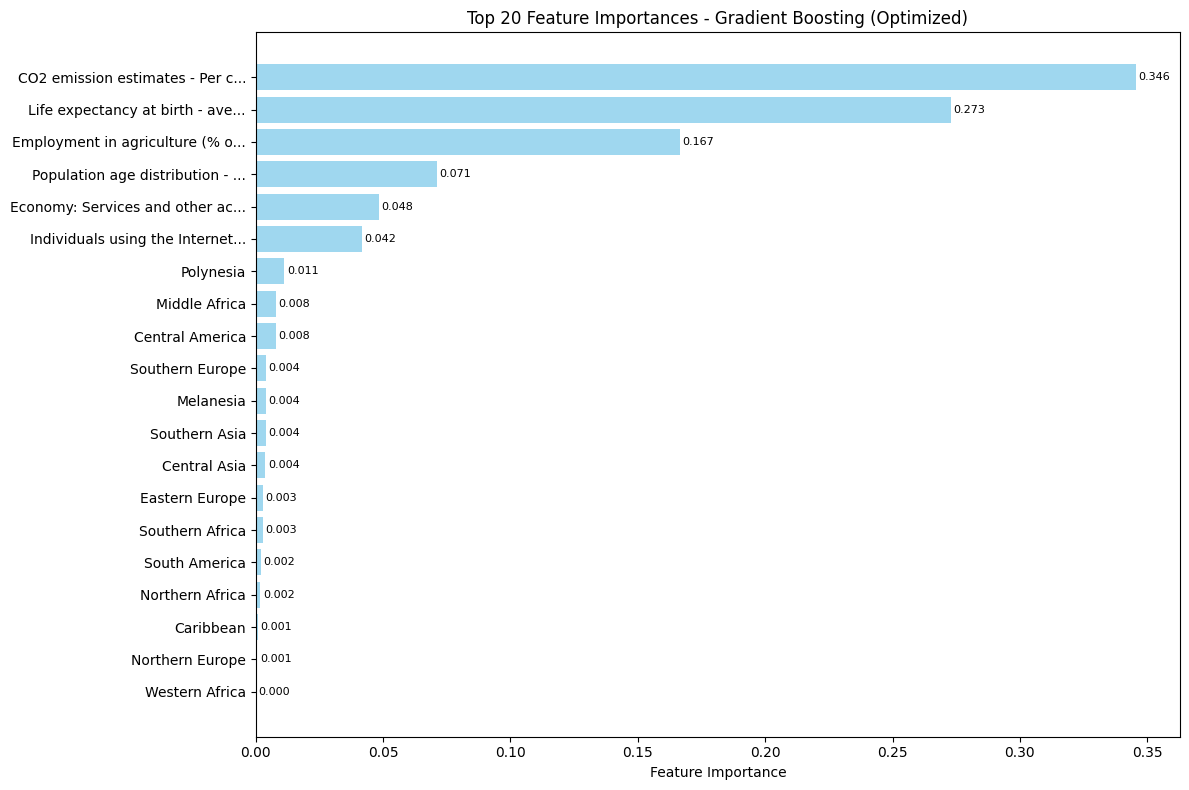


Feature Type Importance Analysis:
Numerical features total importance: 0.9461
Regional features total importance: 0.0539
Numerical/Regional ratio: 17.57


In [79]:
# Feature Importance

# Get the best model for feature importance
best_model_obj = None
if 'Random Forest' in best_model_name:
    if 'Optimized' in best_model_name:
        best_model_obj = optimized_models['Random Forest'].best_estimator_
    else:
        best_model_obj = models['Random Forest']
        best_model_obj.fit(X_train, y_train)
elif 'Gradient Boosting' in best_model_name:
    if 'Optimized' in best_model_name:
        best_model_obj = optimized_models['Gradient Boosting'].best_estimator_
    else:
        best_model_obj = models['Gradient Boosting']
        best_model_obj.fit(X_train, y_train)

# Feature importance (if available)
if best_model_obj and hasattr(best_model_obj, 'feature_importances_'):
    importances = best_model_obj.feature_importances_
    feature_names = X.columns
    
    # Create feature importance dataframe
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False)
    
    print("Top 15 Most Important Features:")
    print("-" * 60)
    for i, (_, row) in enumerate(importance_df.head(15).iterrows()):
        print(f"{i+1:2d}. {row['feature'][:45]:<45} | {row['importance']:.4f}")
    
    # Visualize feature importance
    plt.figure(figsize=(12, 8))
    top_20_features = importance_df.head(20)
    
    bars = plt.barh(range(len(top_20_features)), top_20_features['importance'], color='skyblue', alpha=0.8)
    plt.yticks(range(len(top_20_features)), 
               [name[:30] + '...' if len(name) > 30 else name for name in top_20_features['feature']])
    plt.xlabel('Feature Importance')
    plt.title(f'Top 20 Feature Importances - {best_model_name}')
    plt.gca().invert_yaxis()
    
    # Add importance values on bars
    for i, (bar, imp) in enumerate(zip(bars, top_20_features['importance'])):
        plt.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height()/2, 
                 f'{imp:.3f}', ha='left', va='center', fontsize=8)
    
    plt.tight_layout()
    plt.savefig("../src/visualization/classification/feature_importance_gradient_boosting.png", dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    
    # Feature type analysis
    numerical_features = [f for f in feature_names if f in top_features]
    regional_features = [f for f in feature_names if f not in top_features]
    
    numerical_importance = importance_df[importance_df['feature'].isin(numerical_features)]['importance'].sum()
    regional_importance = importance_df[importance_df['feature'].isin(regional_features)]['importance'].sum()
    
    print(f"\nFeature Type Importance Analysis:")
    print(f"Numerical features total importance: {numerical_importance:.4f}")
    print(f"Regional features total importance: {regional_importance:.4f}")
    print(f"Numerical/Regional ratio: {numerical_importance/regional_importance:.2f}")

else:
    print("Feature importance not available for this model type.")
    print("Consider using Random Forest or Gradient Boosting for feature importance analysis.")

In [ ]:
# Export Classification Models
import joblib
import os
from datetime import datetime

print("💾 EXPORTING CLASSIFICATION MODELS")
print("="*50)

# Create directory
model_dir = '../models/classification/'
os.makedirs(model_dir, exist_ok=True)

# Export best model
best_filename = f"{model_dir}best_classification_model.joblib"
base_name = best_final_model[0].replace(' (Optimized)', '').replace(' (Default)', '')

if base_name in optimized_models:
    best_model = optimized_models[base_name].best_estimator_
    best_params = optimized_models[base_name].best_params_
else:
    best_model = models[base_name]
    best_params = "Default"

best_package = {
    'model': best_model,
    'model_name': best_final_model[0],
    'best_params': best_params,
    'feature_names': list(X.columns),
    'target_classes': sorted(y.unique()),
    'class_labels': {0: 'Lowest GDP', 1: 'Low-Medium GDP', 2: 'Medium-High GDP', 3: 'Highest GDP'},
    'test_accuracy': best_final_model[1]['test_accuracy'],
    'cv_accuracy': best_final_model[1]['cv_accuracy'],
    'export_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

joblib.dump(best_package, best_filename, compress=3)
print(f"🏆 Best model exported -> best_classification_model.joblib")
print(f"   Test Accuracy: {best_final_model[1]['test_accuracy']:.4f}")


💾 EXPORTING CLASSIFICATION MODELS
🏆 Best model exported -> best_classification_model.joblib
   Test Accuracy: 0.8727

✅ ALL MODELS EXPORTED TO: ../models/classification/


In [86]:
# Quick verification test
print("🔍 QUICK VERIFICATION TEST")
print("="*35)

# Test loading and prediction
try:
    best_model_loaded = joblib.load('../models/classification/best_classification_model.joblib')
    model = best_model_loaded['model']
    
    # Test prediction on a sample
    sample_pred = model.predict(X_test.iloc[:1])
    actual = y_test.iloc[0]
    
    print(f"✅ Model loaded and tested successfully!")  
    print(f"   Sample prediction: Class {int(sample_pred[0])}")
    print(f"   Actual value: Class {int(actual)}")
    print(f"   Feature names: {len(best_model_loaded['feature_names'])} features")
    print(f"   Classes: {best_model_loaded['target_classes']}")
    
    # List all exported files
    import glob
    files = glob.glob('../models/classification/*.joblib')
    print(f"\n📁 Files exported ({len(files)} total):")
    for f in sorted(files):
        size_kb = os.path.getsize(f) / 1024
        print(f"   • {os.path.basename(f)} ({size_kb:.1f} KB)")
        
except Exception as e:
    print(f"❌ Error: {e}")

print(f"\n🎉 CLASSIFICATION MODEL EXPORT COMPLETE! 🎉")

🔍 QUICK VERIFICATION TEST
✅ Model loaded and tested successfully!
   Sample prediction: Class 2
   Actual value: Class 2
   Feature names: 28 features
   Classes: [np.float64(0.0), np.float64(1.0), np.float64(2.0), np.float64(3.0)]

📁 Files exported (1 total):
   • best_classification_model.joblib (251.1 KB)

🎉 CLASSIFICATION MODEL EXPORT COMPLETE! 🎉
